In [11]:
#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hr, day, MW
import sys

# osier imports
from osier import DispatchModel
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination

# automatically set the solver
if "darwin" in sys.platform:
    solver = 'cplex_direct'
print(f"Solver set: {solver}")

Solver set: cplex_direct


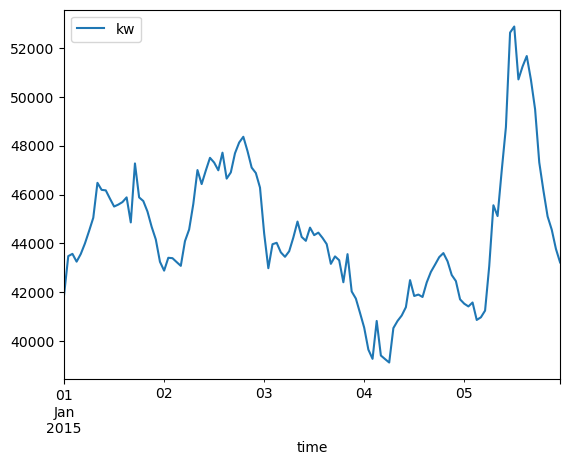

In [13]:
#importing actual UIUC demand data
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/uiuc_demand_data.csv"
demand_data = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True,index_col='time')
dem_vals = demand_data.loc['2015-01-01':'2015-01-05']
dem_vals.plot();plt.show()

#establishing demand data for running in the simulation
demand = dem_vals['kw'].values

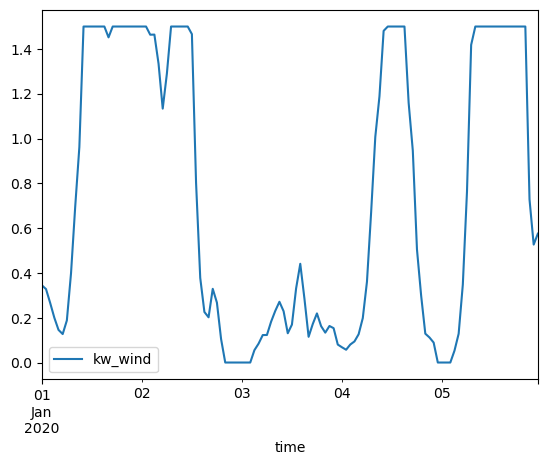

In [14]:
#importing wind data
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/nsrdb_data/windHistory_2020.csv"
wind_power_data = pd.read_csv(url, usecols=['time', 'kw_wind'], parse_dates=True,index_col='time')
wind_power = wind_power_data.loc['2020-01-01':'2020-01-05']
wind_power.plot();plt.show()

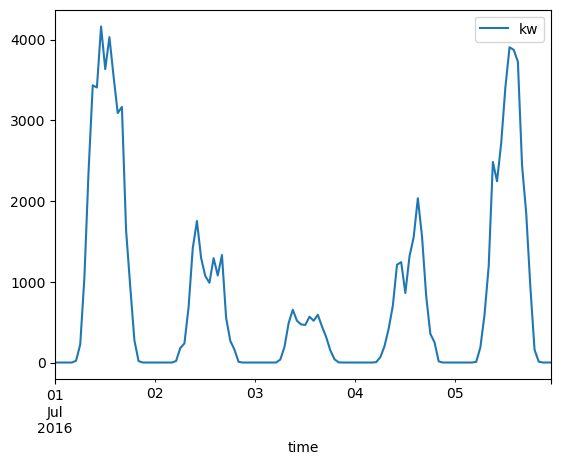

In [15]:
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/solarfarm_data.csv"
solar_power = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True, index_col='time')

# choose a single day
solar_day = solar_power.loc['2016-07-01':'2016-07-05']
solar_day.plot();plt.show()

In [7]:
#getting the energy production values to run in the model

#solar power
solar_day_ener = solar_day['kw'].values
df_solar = pd.DataFrame(solar_day_ener, columns=['Energy'])
solar_ener = df_solar['Energy'].values

#wind power
wind_ener = wind_power['kw_wind'].values


In [8]:
#creating energy mix

#based off osier documentation, we need to include geothermal and add the capacity for coal
#adding capacity of coal, based on research
from osier.tech_library import coal

#finally, create the necessary energy mix
UIUC_mix = [lib.natural_gas,lib.coal,lib.solar,lib.wind]
display(UIUC_mix)


[NaturalGas_Conv: 8375.1331 MW,
 Coal_Conv: 0.0 MW,
 SolarPanel: 2810.3015 MW,
 WindTurbine: 0.0 MW]

In [9]:
#now wanting to do a multi-objective run
#considered total cost, lets consider limitng CO2 emissions
from osier import annual_emission, total_cost
problem2 = CapacityExpansion(technology_list = UIUC_mix,
                            demand=demand*kW,
                            solar=solar_ener,
                            wind=wind_ener,
                            upper_bound= 1 / lib.solar.capacity_credit,
                            objectives = [total_cost,annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [10]:
algorithm = NSGA2(pop_size=20)
termination = RobustTermination(MultiObjectiveSpaceTermination(tol=0.02, n_skip=5), period=10)
import time
start = time.perf_counter()
res = minimize(problem2,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      8 |             - |             -


KeyboardInterrupt: 

In [65]:
#displaying multi-objective results
display(res.F),display(res.X)

array([[2.49080203e+00, 5.16572701e-04],
       [2.40130843e+01, 8.12196190e-05],
       [1.57387977e+01, 9.55018978e-05],
       [8.00297174e+00, 1.53799190e-04],
       [3.17897352e+00, 4.42654691e-04],
       [4.19995334e+00, 3.33096730e-04],
       [5.48101798e+00, 2.31041411e-04],
       [6.00101472e+00, 2.01812161e-04],
       [6.60052456e+00, 1.64588912e-04],
       [1.17325183e+01, 1.18667040e-04],
       [2.02807080e+01, 8.56496852e-05],
       [2.89731443e+00, 4.70611502e-04],
       [4.69997969e+00, 2.85924890e-04],
       [2.16778491e+01, 8.14481212e-05],
       [4.89351852e+00, 2.71587752e-04],
       [3.63212990e+00, 3.84808562e-04],
       [9.88895989e+00, 1.29376887e-04],
       [1.33353513e+01, 1.08489556e-04],
       [2.51601724e+00, 5.04909162e-04],
       [1.78664055e+01, 8.81795510e-05]])

array([[9.30568066e-01, 1.89563574e-02, 8.47429141e-02, 1.96001058e-02],
       [7.13605205e-01, 6.17460227e-01, 5.43157164e-05, 5.26207946e+00],
       [6.74448742e-01, 2.16094860e-02, 1.23250372e-03, 3.70521445e+00],
       [9.06067925e-01, 1.01226950e-02, 8.23653388e-01, 1.17785388e+00],
       [9.30568066e-01, 2.02109754e-02, 4.89849026e-01, 2.41350259e-02],
       [9.03831778e-01, 2.36223441e-02, 9.58352155e-01, 1.03477955e-01],
       [9.03836235e-01, 1.62040230e-02, 6.75885336e-01, 5.72411956e-01],
       [8.64824406e-01, 1.61985040e-02, 7.50779614e-01, 7.01174655e-01],
       [9.11834855e-01, 1.21318777e-02, 9.03499274e-03, 1.15740740e+00],
       [9.30571466e-01, 6.31694230e-03, 2.15127220e-02, 2.49830526e+00],
       [6.74448742e-01, 2.16568144e-02, 1.23250372e-03, 4.90139535e+00],
       [9.26867304e-01, 1.18236858e-02, 2.79937413e-03, 1.72275668e-01],
       [9.11834855e-01, 7.10136527e-03, 1.39901224e-03, 6.63830527e-01],
       [7.18878334e-01, 2.11539307e-03, 5.43157164e

(None, None)

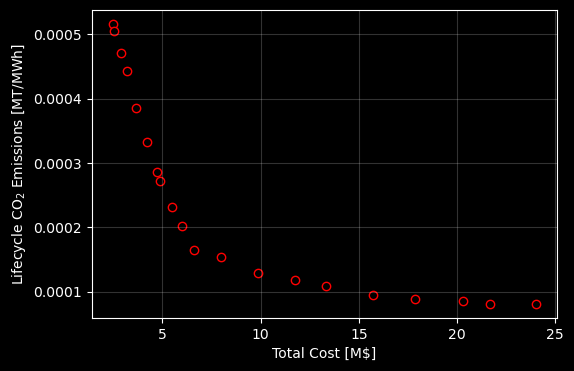

In [67]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()